# Import necessary libraries
SAFEP_parse.py contains all the functions and library calls necessary to run the notebook
# Required libraries:
- numpy
- pandas
- matplotlib
- alchemlyb (pip install git+https://github.com/alchemistry/alchemlyb)
- natsort (for sorting file names)
- glob (for unix-like file paths)



In [1]:
from AFEP_parse import *
plt.rcParams['figure.dpi'] = 150

In [2]:
import os

In [3]:
path='/home/ems363/Documents/ELIC/211/replicaC/'
filename='*.fep*'
fepoutFiles = glob(path+filename)
temperature = 300
RT = 0.00198720650096 * temperature # ca. 0.59kcal/mol
totalSize = 0
for file in fepoutFiles:
    totalSize += os.path.getsize(file)
print(f"Will process {len(fepoutFiles)} fepout files.\nTotal size:{np.round(totalSize/10**9, 2)}GB")

Will process 375 fepout files.
Total size:0.25GB


In [4]:
fepoutFiles = natsorted(fepoutFiles)
maxSize = 10**9 #Don't use the alchemlyb parser if larger than this size. (bytes)
decorrelate = False

# For large data sets: read, decorrelate, save
This reduces RAM requirements between reading and decorrelating

Remember: pickles are not future-proof and should not be used for long-term data storage

In [5]:
from alchemlyb.preprocessing import subsampling

In [ ]:
if totalSize>maxSize:
    method = 'dE'
    affix = f'decorrelated_{method}'

    pickles = []
    idx = 0

    for file in tqdm(fepoutFiles):
        df = readFiles([file])
        u_nk = u_nk_fromDF(df, temperature, 0, warnings=False)

        groups = u_nk.groupby('fep-lambda')
        decorr = pd.DataFrame([])
        for key, group in groups:
            test = subsampling.decorrelate_u_nk(group, method)
            decorr = decorr.append(test)
        u_nk = decorr
        pickle = f"{path}{affix}{idx:03d}.pkl"
        u_nk.to_pickle(pickle)
        pickles.append(pickle)
        idx +=1
        
    pickleDFs = []
    for pickle in pickles:
        pickleDFs.append(pd.read_pickle(pickle))

    u_nk = pd.concat(pickleDFs)

In [ ]:
#u_nk = u_nk.drop(0.975, axis=1) #to remove incomplete windows e.g. when changing lambda resolutions

# Demonstration of equivalence between the above and below methods

In [ ]:
## Demonstrate that AFEP readFiles+u_nk_fromDF is identical to namd.extract_u_nk
## readFiles is more space efficient and can handle single files. Only reads each file once. Less input validation than alchemlyb.namd.
#u_nk_target = namd.extract_u_nk(fepoutFiles[0:5], temperature)
#df = readFiles(fepoutFiles[0:5])
#u_nk_test = u_nk_fromDF(df, temperature, 10000)
#np.all(u_nk_target.fillna(100)==u_nk_test.fillna(100))

# Small data sets can be read and decorrelated sequentially, if desired
See Shirts and Chodera (2008) for more details

"Statistically optimal analysis of samples from multiple equilibrium states" doi: 10.1063/1.2978177

In [6]:
if totalSize < maxSize:
    from alchemlyb.preprocessing import subsampling

    u_nk = namd.extract_u_nk(fepoutFiles, temperature)

    if decorrelate:
        method = 'dE'
        affix = f'decorrelated_{method}'
        groups = u_nk.groupby('fep-lambda')
        decorr = pd.DataFrame([])
        for key, group in groups:
            test = subsampling.decorrelate_u_nk(group, method)
            decorr = decorr.append(test)
        u_nk = decorr
    else:
        affix = 'unprocessed'

else:
    print(f"Warning: The files you are trying to read are quite large. Total size={totalSize}. Try reading and decorrelating (above) or change the maxSize parameter.")

         lambda1 = 0.041667, lambda2 = 0.05; inferring lambda_idws to be 0.033333
         lambda1 = 0.083333, lambda2 = 0.091667; inferring lambda_idws to be 0.075
         lambda1 = 0.125, lambda2 = 0.133333; inferring lambda_idws to be 0.116667
         lambda1 = 0.166667, lambda2 = 0.175; inferring lambda_idws to be 0.158333
         lambda1 = 0.208333, lambda2 = 0.216667; inferring lambda_idws to be 0.2
         lambda1 = 0.25, lambda2 = 0.258333; inferring lambda_idws to be 0.241667
         lambda1 = 0.291667, lambda2 = 0.3; inferring lambda_idws to be 0.283333
         lambda1 = 0.333333, lambda2 = 0.341667; inferring lambda_idws to be 0.325
         lambda1 = 0.375, lambda2 = 0.383333; inferring lambda_idws to be 0.366667
         lambda1 = 0.416667, lambda2 = 0.425; inferring lambda_idws to be 0.408333
         lambda1 = 0.458333, lambda2 = 0.466667; inferring lambda_idws to be 0.45
         lambda1 = 0.5, lambda2 = 0.508333; inferring lambda_idws to be 0.491667
         lamb

# Carry out MBAR Fitting and Analyses

In [ ]:
u_nk = u_nk.sort_index(level=1)

In [ ]:
bar = BAR()
bar.fit(u_nk)

# Extract key features from the MBAR fitting and get ΔG
Note: alchemlyb operates in units of kT by default. We multiply by RT to conver to units of kcal/mol.

In [ ]:
l, l_mid, f, df, ddf, errors = get_MBAR(bar)

print(f'\u0394G = {np.round(f.iloc[-1]*RT, 1)}\u00B1{np.round(errors[-1], 3)} kcal/mol')

# Plot the change in free energy based on MBAR estimates

In [ ]:
# Cumulative change in kT
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.title(f'Cumulative dG with accumulated errors {affix}')
plt.savefig(f'{path}dG_cumulative_kT_{affix}.png', dpi=600)
plt.show()

# Cumulative change in kcal/mol
plt.errorbar(l, f * RT, yerr=errors*RT, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda)(kcal/mol)')
plt.savefig(f'{path}dG_cumulative_kcal_per_mol_{affix}.png', dpi=600)
plt.show()

# Per-window change in kT
plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.title(f'Per-Window dG with individual errors {affix}')
plt.savefig(f'{path}dG_{affix}.png', dpi=600)
plt.show()


# Plot the estimated total change in free energy as a function of simulation time; contiguous subsets starting at t=0 ("Forward") and t=end ("Reverse")

In [ ]:
convergence_plot(u_nk, l)
plt.title(f'Convergence {affix}')
plt.savefig(f'{path}convergence_{affix}.png', dpi=600)

# Use an exponential estimator to assess residual discrepancies and check for hysteresis

In [10]:
l, l_mid, dG_f, dG_b = get_EXP(u_nk)

/u2/home_u2/ems363/safep/AFEP_parse.py:243: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dG[name] = np.log(np.mean(np.exp(-1*group)))


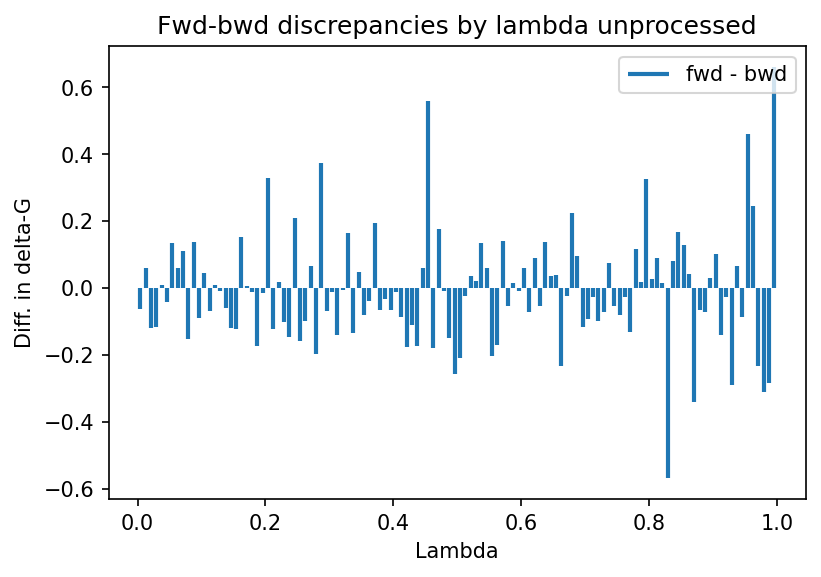

In [11]:
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=2)

plt.legend()
plt.title(f'Fwd-bwd discrepancies by lambda {affix}')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')
plt.savefig(f'{path}discrepancies_{affix}.png', dpi=600)

# The above data should follow a roughly normal distribution centered on 0. Use a histogram to estimate the PDF.

In [12]:
diff = dG_f + np.array(dG_b)
diff.sort()
X = diff
Y = np.arange(len(X))/len(X)

#fit a normal distribution to the existing data
fitted = norm.fit(X)

dx = 0.01
Xnorm  = np.arange(np.min(X), np.max(X), dx)

Ynorm = norm.pdf(Xnorm, fitted[0], fitted[1])

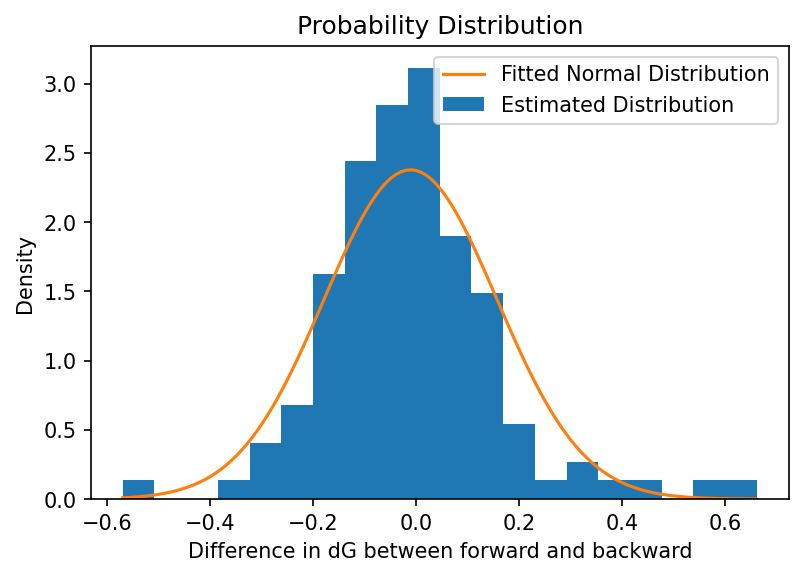

In [13]:
fig, ax = plt.subplots(1,1)

binNum = 20
window = binNum
#dydx = getMovingAveSlope(X, Y, window)
#e = int(window/2)
hist = ax.hist(dG_f + np.array(dG_b), bins=binNum, density=True, label="Estimated Distribution");
ax.plot(Xnorm, Ynorm, label="Fitted Normal Distribution")

plt.title("Probability Distribution")
plt.xlabel("Difference in dG between forward and backward")
plt.ylabel("Density")
plt.legend()
#axins.tick_params(labelleft=False, labelbottom=False)
plt.savefig(f"{path}DistributionOfDiscrepancies_{affix}.png", dpi=600)
plt.show()

# OPTIONAL: Estimate and plot the Cumulative Density function (CDF) for the differences shown above.

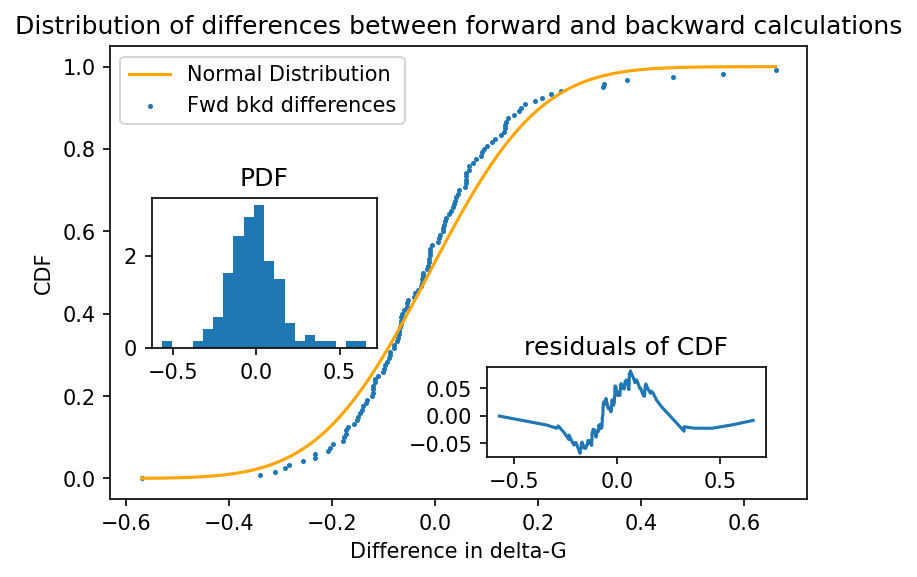

In [14]:
#fit a normal distribution to the existing data
fitted = norm.fit(X)

dx = 0.01
Xnorm  = np.arange(np.min(X), np.max(X), dx)

Ynorm = norm.cdf(Xnorm, fitted[0], fitted[1])
Yexpected = norm.cdf(X, fitted[0], fitted[1])

#plot the data as they are (estimate the CDF) and the fitted cdf
fig, ax = plt.subplots(1, 1)
plt.xlabel('Difference in delta-G')
plt.ylabel("CDF")
plt.title("Distribution of differences between forward and backward calculations")

ax.scatter(X, Y, 2, label="Fwd bkd differences")
ax.plot(Xnorm, Ynorm, label="Normal Distribution", color="orange")
 
binNum = 20
window = binNum
#dydx = getMovingAveSlope(X, Y, window)
#e = int(window/2)
axins = inset_axes(ax, width=1.5, height=1, loc="center left", borderpad=2)
axins.hist(dG_f + np.array(dG_b), bins=binNum, density=True);
#axins.plot(X[e:-e], dydx[:-1], color="gray")
axins.set_title("PDF")
#axins.tick_params(labelleft=False, labelbottom=False)
    
residuals = Y-Yexpected
axins2 = inset_axes(ax, width="40%", height="20%", loc=4, borderpad=2)
axins2.plot(X, residuals)
axins2.set_title("residuals of CDF")
#axins2.tick_params(labelleft=False, labelbottom=False)

ax.legend()

plt.savefig(f"{path}DistributionOfDifferences{affix}.png", dpi=600)
plt.show()

In [31]:
from scipy.special import erfc
from scipy.optimize import curve_fit as scipyFit
#Wrapper for fitting the normal CDF
def cumFn(x, m, s):
    r = norm.cdf(x, m, s)
    return r

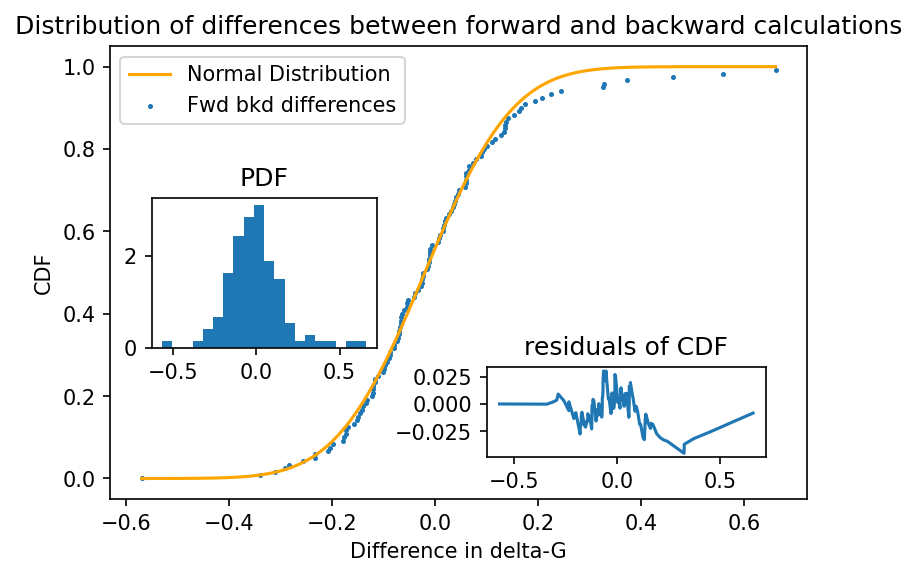

In [33]:
#fit a normal distribution to the existing data
fitted = scipyFit(cumFn, X, Y)[0]

dx = 0.01
Xnorm  = np.arange(np.min(X), np.max(X), dx)

Ynorm = norm.cdf(Xnorm, fitted[0], fitted[1])
Yexpected = norm.cdf(X, fitted[0], fitted[1])

#plot the data as they are (estimate the CDF) and the fitted cdf
fig, ax = plt.subplots(1, 1)
plt.xlabel('Difference in delta-G')
plt.ylabel("CDF")
plt.title("Distribution of differences between forward and backward calculations")

ax.scatter(X, Y, 2, label="Fwd bkd differences")
ax.plot(Xnorm, Ynorm, label="Normal Distribution", color="orange")
 
binNum = 20
window = binNum
#dydx = getMovingAveSlope(X, Y, window)
#e = int(window/2)
axins = inset_axes(ax, width=1.5, height=1, loc="center left", borderpad=2)
axins.hist(dG_f + np.array(dG_b), bins=binNum, density=True);
#axins.plot(X[e:-e], dydx[:-1], color="gray")
axins.set_title("PDF")
#axins.tick_params(labelleft=False, labelbottom=False)
    
residuals = Y-Yexpected
axins2 = inset_axes(ax, width="40%", height="20%", loc=4, borderpad=2)
axins2.plot(X, residuals)
axins2.set_title("residuals of CDF")
#axins2.tick_params(labelleft=False, labelbottom=False)

ax.legend()

plt.savefig(f"{path}DistributionOfDifferences{affix}.png", dpi=600)
plt.show()